In [ ]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
ENCODING_DICT = {
            'a': 0,
            'f': 1,
            'e': 2,
            'c': 3,
            'b': 4,
            'h': 5,
            'v': 6,
            'z': 7,
            '2': 8,
            'x': 9,
            'g': 10,
            'm': 11,
            'r': 12,
            'u': 13,
            'p': 14,
            's': 15,
            'd': 16,
            'n': 17,
            '6': 18,
            'k': 19,
            't': 20
            }

DECODING_DICT = {
            0: 'a',
            1: 'f',
            2: 'e',
            3: 'c',
            4: 'b',
            5: 'h',
            6: 'v',
            7: 'z',
            8: '2',
            9: 'x',
            10: 'g',
            11: 'm',
            12: 'r',
            13: 'u',
            14: 'p',
            15: 's',
            16: 'd',
            17: 'n',
            18: '6',
            19: 'k',
            20: 't'
            }

In [ ]:
def imagepath_to_captcha(imagepath):
    return imagepath.split("_")[1].split(".")[0]

def to_onehot(captcha):
    label = np.zeros((len(captcha), len(ENCODING_DICT)))
    for index, char in enumerate(captcha):
        label[index, ENCODING_DICT[char]] = 1
    return tf.convert_to_tensor(label, tf.float32)
    # return tf.reshape(tf.convert_to_tensor(label, tf.float32), [-1])

def captcha_from_onehot(tensor):
    label = []
    for index in tf.argmax(tensor, 1).numpy():
        label.append(DECODING_DICT[index])
    return "".join(label)

def load_dataset(filepath):
    filenames = os.listdir(filepath)
    x, y = [], []
    for file in filenames:
        imagepath = filepath + "/" + file
        image = tf.io.read_file(imagepath)
        image = tf.image.decode_image(image)
        pixels = tf.image.convert_image_dtype(image, tf.float32)
        # To show images: 
        # plt.imshow(tf.reshape(pixels, image.shape))
        # plt.title('Image as Pixels')
        # plt.show()
        x.append(pixels)
        captcha = imagepath_to_captcha(file).lower()
        y.append(to_onehot(captcha))
    return (tf.convert_to_tensor(x, tf.float32), tf.convert_to_tensor(y, tf.float32))


# Read input data

In [45]:
train_x, train_y = load_dataset("dataset/train")
test_x, test_y = load_dataset("dataset/test")

print("Training input shape:", train_x.shape)
print("Training output shape:", train_y.shape)
print("Testing input shape:", test_x.shape)
print("Testing output shape:", test_y.shape)

Training input shape: (8501, 50, 250, 3)
Training output shape: (8501, 6, 21)
Testing input shape: (1500, 50, 250, 3)
Testing output shape: (1500, 6, 21)


In [46]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(128, (4, 4),
                            #   kernel_regularizer=keras.regularizers.L2(1e-4), 
                              activation='relu', input_shape=(50, 250, 3)))
# model.add(keras.layers.AveragePooling2D(2, 2))
model.add(keras.layers.MaxPooling2D(3, 3))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Conv2D(64, (2, 2), activation='sigmoid'))
# model.add(keras.layers.MaxPooling2D(2, 2))
# model.add(keras.layers.Dropout(0.08))

model.add(keras.layers.Conv2D(64, (2, 2),
                              # kernel_regularizer=keras.regularizers.L2(1e-4), 
                              activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))

model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(8064, activation='relu'))
# model.add(keras.layers.Dense(1440, activation='relu'))
# model.add(keras.layers.Dense(504, activation=keras.layers.LeakyReLU(alpha=0.1)))
# model.add(keras.layers.Dense(504, activation='relu'))
model.add(keras.layers.Dropout(0.09))
# model.add(keras.layers.Dense(units=252,
#             kernel_regularizer=keras.regularizers.L2(5 * 1e-4),
#             activation='relu'))
# model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(252, activation='relu'))
model.add(keras.layers.Dense(126, activation='softmax'))
model.add(keras.layers.Reshape((6, 21)))


model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 47, 247, 128)      6272      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 15, 82, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 81, 64)        32832     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 7, 40, 64)         0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 17920)             0         
                                                                 
 dropout_10 (Dropout)        (None, 17920)            

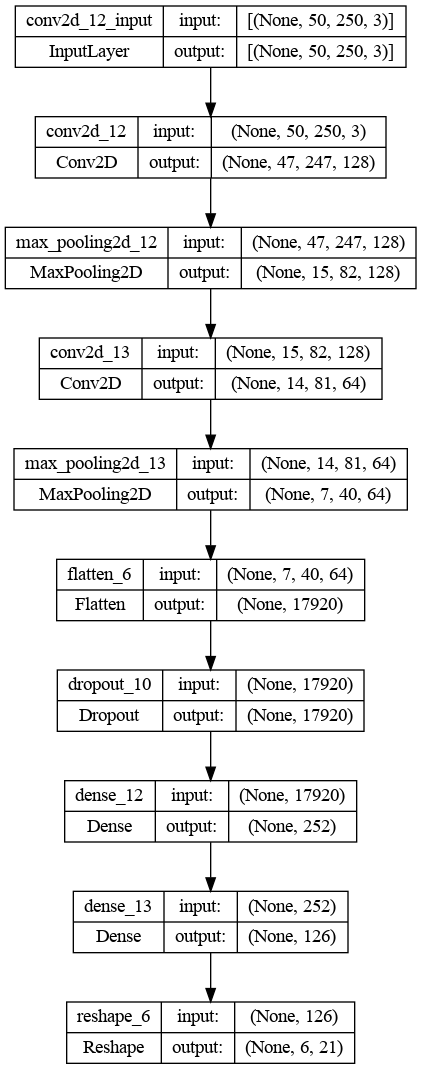

In [47]:


model.compile(
    optimizer = "adam",
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

# graphwiz doesn't install on gLinux ffs.
tf.keras.utils.plot_model(model, show_shapes=True)


In [48]:
callbacks = [keras.callbacks.EarlyStopping(monitor = 'loss', 
                                           patience = 2, 
                                           restore_best_weights = True)]

history = model.fit(train_x, train_y,
                    epochs = 5,
                    batch_size = 32,
                    callbacks = callbacks)

print(history.history)

Epoch 1/5
266/266 [==============================] - 270s 1s/step - loss: 2.6676 - accuracy: 0.1725
Epoch 2/5
266/266 [==============================] - 268s 1s/step - loss: 1.1975 - accuracy: 0.6172
Epoch 3/5
266/266 [==============================] - 229s 861ms/step - loss: 0.4448 - accuracy: 0.8587
Epoch 4/5
266/266 [==============================] - 249s 936ms/step - loss: 0.1943 - accuracy: 0.9389
Epoch 5/5
266/266 [==============================] - 246s 925ms/step - loss: 0.1121 - accuracy: 0.9653
{'loss': [2.6676025390625, 1.197530746459961, 0.44477012753486633, 0.19425168633460999, 0.11214157938957214], 'accuracy': [0.1725287288427353, 0.6172410845756531, 0.8586636781692505, 0.9388699531555176, 0.9652785658836365]}


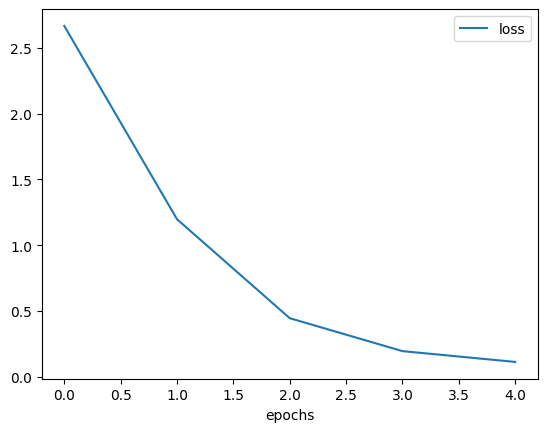

In [49]:
plt.plot(history.history['loss'], label = 'loss')
# plt.plot(1 - np.array(history.history['accuracy']), label = 'accuracy')
plt.legend()
plt.xlabel('epochs')
plt.show()

In [50]:
model.evaluate(test_x, test_y)

47/47 [==============================] - 12s 253ms/step - loss: 0.6188 - accuracy: 0.8360


[0.618806004524231, 0.8360000252723694]